# 03 — Mutual Information Exploration (Synthetic Benchmark)

**Goal:** Benchmark mutual-information estimators on synthetic data whose
information-theoretic quantities are known analytically.

| Section | Content |
|---|---|
| **1. Dataset Generation** | XOR-structured binary classification with correlated and independent nuisance features |
| **2. Analytical Ground Truths** | Closed-form MI / CMI / co-information values in nats |
| **3+.** *(later)* | Estimator benchmarking & comparison |

## 1. Dataset Generation

We generate $N = 2\,000$ samples from the following model:

| Variable | Distribution | Role |
|---|---|---|
| $X_1$ | $\mathrm{Uniform}(-1, 1)$ | XOR input 1 |
| $X_2$ | $\mathrm{Uniform}(-1, 1)$, independent of $X_1$ | XOR input 2 |
| $Y$ | $\mathbf{1}[X_1 \cdot X_2 > 0]$ | Binary label (deterministic XOR) |
| $(X_3, X_4)$ | $\mathrm{BivariateNormal}\!\bigl(\mathbf{0},\; \bigl[\begin{smallmatrix}1 & \rho \\ \rho & 1\end{smallmatrix}\bigr]\bigr)$, $\rho = 0.8$ | Correlated nuisance pair |
| $X_5$ | $\mathcal{N}(0, 1)$, independent of everything | Pure noise |
| $X_6$ | $X_6\mid Y=0 \sim \mathcal{N}(0,1)$, $X_6\mid Y=1 \sim \mathcal{N}(\mu,1)$ with $\mu=1.0$ | Univariate signal for $Y$ |

**XOR structure:** $X_1$ and $X_2$ are each *marginally* independent of $Y$
(symmetric around 0 in both classes), yet they *jointly* determine $Y$
perfectly.  This makes $I(X_1; Y) = I(X_2; Y) = 0$ while
$I(X_1, X_2;\, Y) = \ln 2$ — a canonical example of **synergy**.

In [1]:
import sys

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.styles.colors import get_colors

# ── Colour setup ────────────────────────────────────────────
COLOR      = get_colors("palette")
COLORS     = get_colors("categorical")

# ── Global parameters ───────────────────────────────────────
SEED = 42
N    = 2000
RHO  = 0.95
MU   = 1.5

# ── Random number generator ────────────────────────────────
rng = np.random.default_rng(SEED)

# ── Generate features ──────────────────────────────────────
X1 = rng.uniform(-1, 1, N)
X2 = rng.uniform(-1, 1, N)

Y = (X1 * X2 > 0).astype(int)

cov = [[1, RHO], [RHO, 1]]
X3X4 = rng.multivariate_normal([0, 0], cov, N)
X3 = X3X4[:, 0]
X4 = X3X4[:, 1]

X5 = rng.standard_normal(N)
X6 = rng.standard_normal(N) + MU * Y

# ── Assemble DataFrame ─────────────────────────────────────
df = pd.DataFrame(
    {"X1": X1, "X2": X2, "X3": X3, "X4": X4, "X5": X5, "X6": X6, "Y": Y}
)

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print()
print(df.head())
print()
print("Class balance (Y):")
print(df["Y"].value_counts(normalize=True).rename({0: "Y=0", 1: "Y=1"}))

Shape: (2000, 7)
Columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y']

         X1        X2        X3        X4        X5        X6  Y
0  0.547912  0.685464  1.264154  0.790868 -1.128436  0.265883  1
1 -0.122243 -0.107221 -1.718602 -0.952557 -2.536430  1.255253  1
2  0.717196  0.905950  0.678542  0.260987  0.595387  1.112515  1
3  0.394736  0.301589  2.247384  2.170190 -0.261827  0.802295  1
4 -0.811645 -0.768202  0.415365  0.209407 -0.162150  1.747923  1

Class balance (Y):
Y
Y=1    0.5025
Y=0    0.4975
Name: proportion, dtype: float64


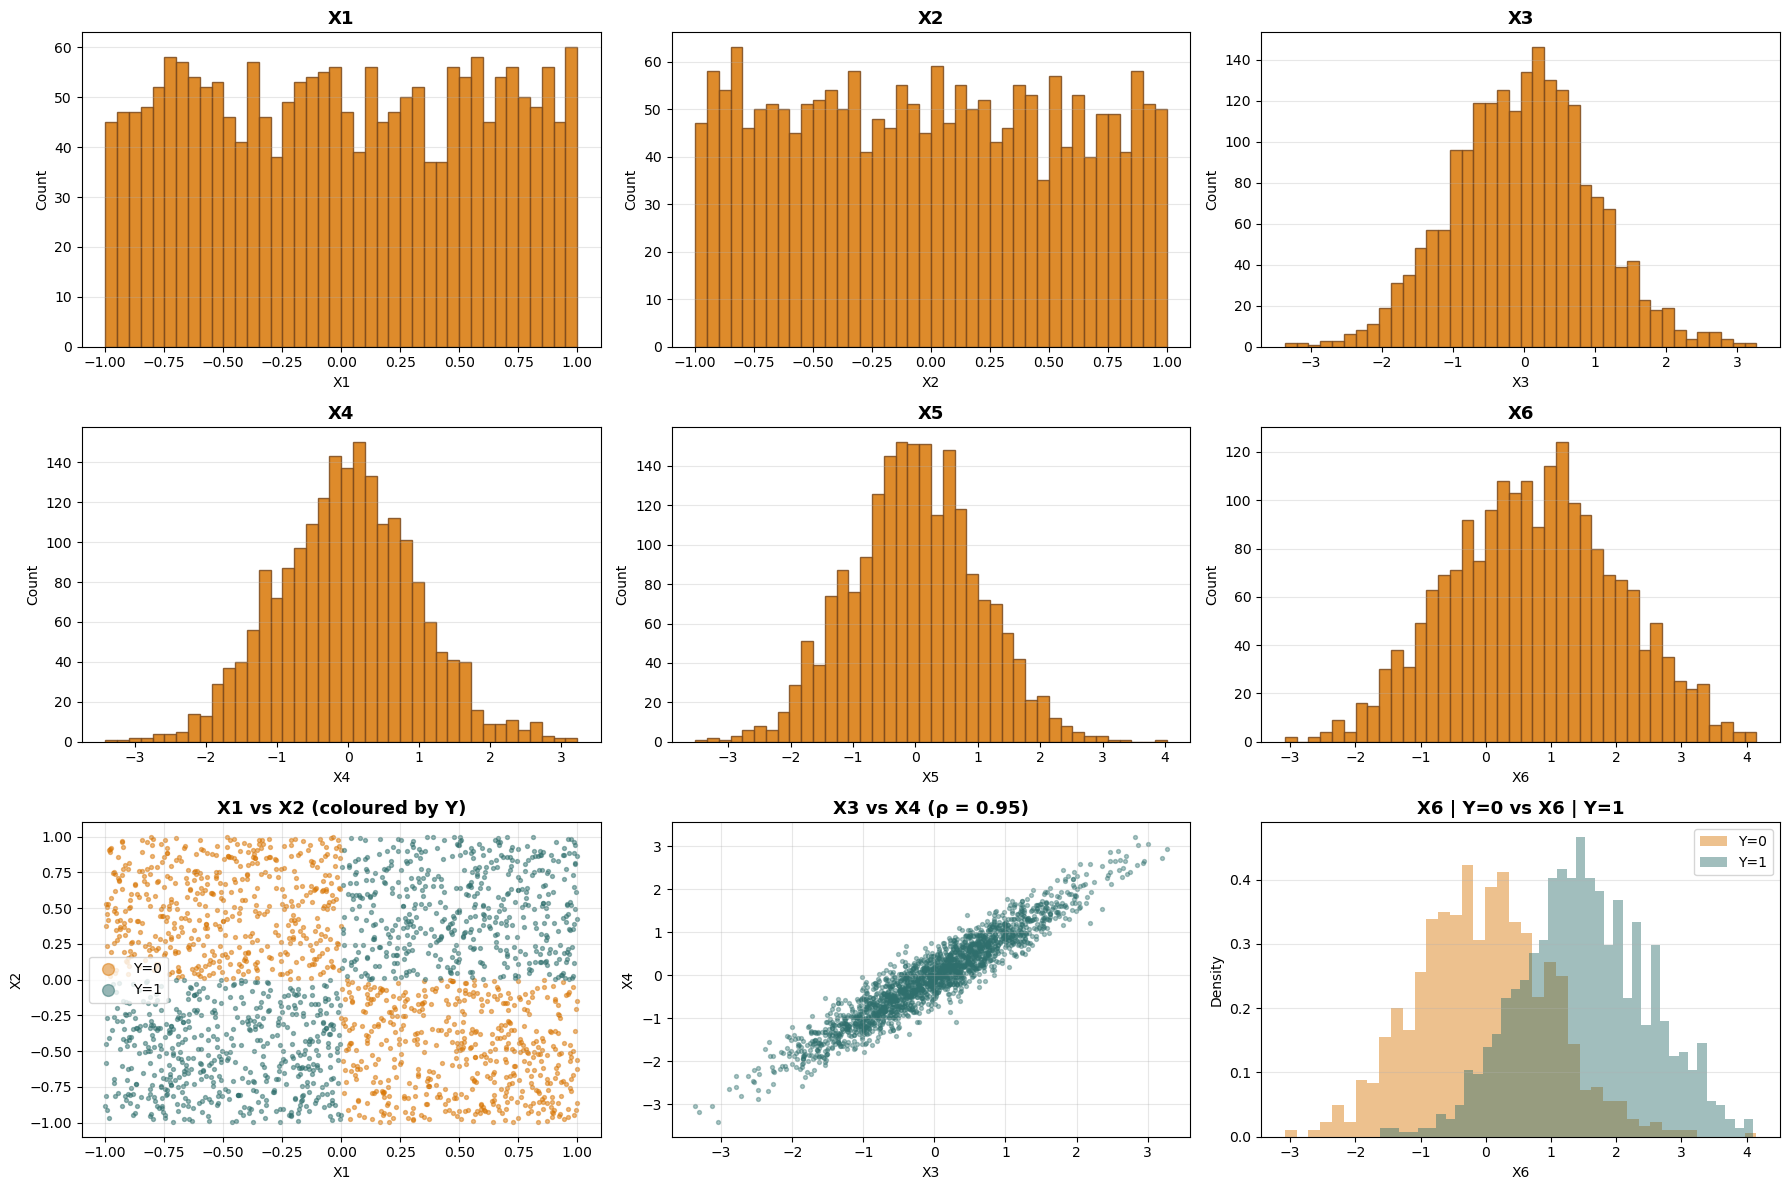

In [2]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

# ── Histograms for X1–X6 ───────────────────────────────────
hist_kw = dict(bins=40, color=COLOR["primary"], edgecolor=COLOR["neutral"], alpha=0.85)

for i, col in enumerate(["X1", "X2", "X3", "X4", "X5", "X6"]):
    ax = axes[i]
    ax.hist(df[col], **hist_kw)
    ax.set_title(col, fontsize=13, fontweight="bold")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.grid(axis="y", alpha=0.3)

# ── Scatter: X1 vs X2 coloured by Y (XOR structure) ───────
ax = axes[6]
for label, colour in zip([0, 1], COLORS[:2]):
    mask = df["Y"] == label
    ax.scatter(
        df.loc[mask, "X1"],
        df.loc[mask, "X2"],
        c=colour,
        label=f"Y={label}",
        s=8,
        alpha=0.5,
    )
ax.set_title("X1 vs X2 (coloured by Y)", fontsize=13, fontweight="bold")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.legend(markerscale=3)
ax.grid(alpha=0.3)

# ── Scatter: X3 vs X4 (correlated pair) ───────────────────
ax = axes[7]
ax.scatter(df["X3"], df["X4"], c=COLOR["secondary"], s=8, alpha=0.4)
ax.set_title(f"X3 vs X4 (ρ = {RHO})", fontsize=13, fontweight="bold")
ax.set_xlabel("X3")
ax.set_ylabel("X4")
ax.grid(alpha=0.3)

# ── Overlay: conditional distributions of X6 given Y ──────
ax = axes[8]
for label, colour in zip([0, 1], COLORS[:2]):
    vals = df.loc[df["Y"] == label, "X6"]
    ax.hist(vals, bins=40, density=True, alpha=0.45, color=colour, label=f"Y={label}")
ax.set_title("X6 | Y=0 vs X6 | Y=1", fontsize=13, fontweight="bold")
ax.set_xlabel("X6")
ax.set_ylabel("Density")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Analytical Ground Truths

All values are in **nats** (natural logarithm).

| Quantity | Value | Justification |
|---|---|---|
| $I(X_1;\,Y)$ | $0$ | $X_1$ is symmetric around 0; its marginal is identical in both classes. |
| $I(X_2;\,Y)$ | $0$ | Same symmetry argument as $X_1$. |
| $I(X_1;\,X_2)$ | $0$ | Independent by construction. |
| $I(X_3;\,X_4)$ | $-\tfrac{1}{2}\ln(1-\rho^2)$ | Standard bivariate-normal MI formula. |
| $I(X_3;\,Y)$ | $0$ | $(X_3, X_4)$ are generated independently of $(X_1, X_2, Y)$. |
| $I(X_4;\,Y)$ | $0$ | Same independence as $X_3$. |
| $I(X_5;\,Y)$ | $0$ | Pure noise, independent of everything. |
| $I(X_6;\,Y)$ | numeric | $X_6$ is a Gaussian location mixture. $h(X_6\mid Y)$ is analytic, while $h(X_6)$ has no closed form and is computed by numerical quadrature. |
| $I(X_1, X_2;\,Y)$ | $\ln 2$ | $Y$ is a deterministic, balanced function of $(X_1,X_2)$, so $H(Y\mid X_1,X_2)=0$ and $H(Y)=\ln 2$. |
| $I(X_1;\,X_2 \mid Y)$ | $\ln 2$ | Conditioning on $Y$ restricts $(X_1,X_2)$ to two diagonal quadrants; within each class $X_1$ and $X_2$ become dependent. Chain rule: $I(X_1;X_2\mid Y) = I(X_1,X_2;Y) - I(X_1;Y) - I(X_2;Y) = \ln 2$. |
| $I(X_1;\,Y \mid X_2)$ | $\ln 2$ | Given $X_2$, the sign of $X_1$ determines $Y$. Chain rule: $I(X_1;Y\mid X_2) = I(X_1,X_2;Y) - I(X_2;Y) = \ln 2$. |
| $I(X_3;\,X_4 \mid Y)$ | $-\tfrac{1}{2}\ln(1-\rho^2)$ | $(X_3,X_4) \perp Y$, so conditioning on $Y$ does not change their joint. |
| $II(X_1;\,X_2;\,Y)$ | $-\ln 2$ | Co-information $= I(X_1;Y) - I(X_1;Y\mid X_2) = 0 - \ln 2$. Negative sign indicates **synergy**: $X_1$ and $X_2$ are individually uninformative but jointly fully informative about $Y$. |

In [3]:
from scipy import integrate
from scipy.stats import norm


def gaussian_mixture_entropy(mu, sigma=1.0, p=0.5):
    def mixture_pdf(x):
        return p * norm.pdf(x, 0, sigma) + (1 - p) * norm.pdf(x, mu, sigma)

    def integrand(x):
        px = mixture_pdf(x)
        return -px * np.log(px + 1e-300)

    val, _ = integrate.quad(integrand, -20, 20 + mu)
    return val


h_X6 = gaussian_mixture_entropy(mu=MU)
h_X6_given_Y = 0.5 * np.log(2 * np.pi * np.e)
I_X6_Y = h_X6 - h_X6_given_Y

# ── Ground-truth MI values (nats) ───────────────────────────
ground_truth = {
    "I(X1;Y)":          0.0,
    "I(X2;Y)":          0.0,
    "I(X1;X2)":         0.0,
    "I(X3;X4)":         -0.5 * np.log(1 - RHO**2),
    "I(X3;Y)":          0.0,
    "I(X4;Y)":          0.0,
    "I(X5;Y)":          0.0,
    "I(X6;Y)":          I_X6_Y,
    "I(X1,X2;Y)":       np.log(2),
    "I(X1;X2|Y)":       np.log(2),
    "I(X1;Y|X2)":       np.log(2),
    "I(X3;X4|Y)":       -0.5 * np.log(1 - RHO**2),
    "II(X1;X2;Y)":      -np.log(2)
}

# ── Display as formatted table ─────────────────────────────
gt_df = pd.DataFrame(
    [{"Quantity": k, "True value (nats)": round(v, 4)} for k, v in ground_truth.items()]
)
print(gt_df.to_string(index=False))

   Quantity  True value (nats)
    I(X1;Y)             0.0000
    I(X2;Y)             0.0000
   I(X1;X2)             0.0000
   I(X3;X4)             1.1640
    I(X3;Y)             0.0000
    I(X4;Y)             0.0000
    I(X5;Y)             0.0000
    I(X6;Y)             0.2212
 I(X1,X2;Y)             0.6931
 I(X1;X2|Y)             0.6931
 I(X1;Y|X2)             0.6931
 I(X3;X4|Y)             1.1640
II(X1;X2;Y)            -0.6931


## Compare with information evaluation tools

In [4]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from npeet import entropy_estimators as ee
import infomeasure as im

### Sklearn

sklearn provides two kNN-based MI estimators (Kraskov / Ross, 2014):

| Function | Use case | Constraint |
|---|---|---|
| `mutual_info_classif(X, y)` | continuous $X$, **discrete** $y$ | Per-feature only, no CMI |
| `mutual_info_regression(X, y)` | continuous $X$, **continuous** $y$ | Per-feature only, no CMI |

In [5]:
sklearn_values = {
    "I(X1;Y)":          mutual_info_classif(df[["X1"]].values, Y)[0],
    "I(X2;Y)":          mutual_info_classif(df[["X2"]].values, Y)[0],
    "I(X1;X2)":         mutual_info_regression(df[["X1"]].values, df["X2"].values)[0],
    "I(X3;X4)":         mutual_info_regression(df[["X3"]].values, df["X4"].values)[0],
    "I(X3;Y)":          mutual_info_classif(df[["X3"]].values, Y)[0],
    "I(X4;Y)":          mutual_info_classif(df[["X4"]].values, Y)[0],
    "I(X5;Y)":          mutual_info_classif(df[["X5"]].values, Y)[0],
    "I(X6;Y)":          mutual_info_classif(df[["X6"]].values, Y)[0],
    "I(X1,X2;Y)":       np.nan,
    "I(X1;X2|Y)":       np.mean(Y==1) * mutual_info_regression(df.loc[Y==1, ["X1"]].values, df.loc[Y==1, "X2"].values)[0] + np.mean(Y==0) * mutual_info_regression(df.loc[Y==0, ["X1"]].values, df.loc[Y==0, "X2"].values)[0],
    "I(X1;Y|X2)":       np.nan,
    "I(X3;X4|Y)":       np.mean(Y==1) * mutual_info_regression(df.loc[Y==1, ["X3"]].values, df.loc[Y==1, "X4"].values)[0] + np.mean(Y==0) * mutual_info_regression(df.loc[Y==0, ["X3"]].values, df.loc[Y==0, "X4"].values)[0],
    "II(X1;X2;Y)":      mutual_info_regression(df[["X1"]].values, df["X2"].values)[0] - np.mean(Y==1) * mutual_info_regression(df.loc[Y==1, ["X1"]].values, df.loc[Y==1, "X2"].values)[0] - np.mean(Y==0) * mutual_info_regression(df.loc[Y==0, ["X1"]].values, df.loc[Y==0, "X2"].values)[0]
}
# ── Display as formatted table ─────────────────────────────
sk_df = pd.DataFrame(
    [{"Quantity": k, "Sklearn value (nats)": round(v, 4)} for k, v in sklearn_values.items()]
)
print(sk_df.to_string(index=False))

   Quantity  Sklearn value (nats)
    I(X1;Y)                0.0117
    I(X2;Y)                0.0000
   I(X1;X2)                0.0000
   I(X3;X4)                1.1100
    I(X3;Y)                0.0000
    I(X4;Y)                0.0103
    I(X5;Y)                0.0053
    I(X6;Y)                0.2241
 I(X1,X2;Y)                   NaN
 I(X1;X2|Y)                0.6570
 I(X1;Y|X2)                   NaN
 I(X3;X4|Y)                1.1401
II(X1;X2;Y)               -0.6570


### NPEET


[NPEET](https://github.com/gregversteeg/NPEET) (Non-Parametric Entropy Estimation Toolbox, Ver Steeg & Galstyan 2014) uses kNN-based estimators for **continuous** variables.

**Installation:** `pip install npeet`  
**Import:** `from npeet import entropy_estimators as ee`

| Function | Description |
|---|---|
| `ee.entropy(x, k)` | Differential entropy $h(X)$; `x` must be shape `(n, d)` |
| `ee.mi(x, y, k)` | $I(X;Y)$ for continuous $X, Y$ |
| `ee.cmi(x, y, z, k)` | $I(X;Y \mid Z)$ for continuous $X, Y, Z$ |


In [6]:
npeet_values = {
    "I(X1;Y)":          ee.micd(df[["X1"]].values, Y.reshape(-1, 1)),
    "I(X2;Y)":          ee.micd(df[["X2"]].values, Y.reshape(-1, 1)),
    "I(X1;X2)":         ee.mi(df[["X1"]].values, df["X2"].values),
    "I(X3;X4)":         ee.mi(df[["X3"]].values, df[["X4"]].values),
    "I(X3;Y)":          ee.micd(df[["X3"]].values, Y.reshape(-1, 1)),
    "I(X4;Y)":          ee.micd(df[["X4"]].values, Y.reshape(-1, 1)),
    "I(X5;Y)":          ee.micd(df[["X5"]].values, Y.reshape(-1, 1)),
    "I(X6;Y)":          ee.micd(df[["X6"]].values, Y.reshape(-1, 1)),
    "I(X1,X2;Y)":       ee.micd(np.c_[X1, X2], Y.reshape(-1, 1)), #ee.entropy(df[["X1", "X2"]].values) - np.mean(Y==1) * ee.entropy(df.loc[Y==1, ["X1", "X2"]].values) - np.mean(Y==0) * ee.entropy(df.loc[Y==0, ["X1", "X2"]].values),
    "I(X1;X2|Y)":       ee.mi(df[["X1"]].values, df["X2"].values, Y.reshape(-1, 1)), #np.mean(Y==1) * ee.mi(df.loc[Y==1, ["X1"]].values, df.loc[Y==1, ["X2"]].values) + np.mean(Y==0) * ee.mi(df.loc[Y==0, ["X1"]].values, df.loc[Y==0, ["X2"]].values),
    "I(X1;Y|X2)":       ee.mi(df[["X1"]].values, Y.reshape(-1, 1), df[["X2"]].values), 
    "I(X3;X4|Y)":       ee.mi(df[["X3"]].values, df["X4"].values, Y.reshape(-1, 1)), #np.mean(Y==1) * ee.mi(df.loc[Y==1, ["X3"]].values, df.loc[Y==1, ["X4"]].values) + np.mean(Y==0) * ee.mi(df.loc[Y==0, ["X3"]].values, df.loc[Y==0, ["X4"]].values),
    "II(X1;X2;Y)":      ee.mi(df[["X1"]].values, df["X2"].values) - ee.mi(df[["X1"]].values, df[["X2"]].values, Y.reshape(-1, 1)),
}
# ── Display as formatted table ─────────────────────────────
npeet_df = pd.DataFrame(
    [{"Quantity": k, "Npeet value (nats)": round(v*np.log(2), 4)} for k, v in npeet_values.items()]
)
print(npeet_df.to_string(index=False))

   Quantity  Npeet value (nats)
    I(X1;Y)              0.0104
    I(X2;Y)              0.0507
   I(X1;X2)             -0.0166
   I(X3;X4)              1.1099
    I(X3;Y)              0.0196
    I(X4;Y)              0.0016
    I(X5;Y)              0.0151
    I(X6;Y)              0.2080
 I(X1,X2;Y)              0.6699
 I(X1;X2|Y)              0.6568
 I(X1;Y|X2)              0.6677
 I(X3;X4|Y)              1.1399
II(X1;X2;Y)             -0.6734


### Infomeasure

[infomeasure](https://github.com/cbueth/infomeasure) provides a unified API over multiple MI estimators (KSG, kernel, plugin/discrete, JIDT).

**Installation:** `pip install infomeasure`  

Key functions (all return values in **nats** by default):

```python
import infomeasure as im

im.mutual_information(x, y, approach='metric', k=5)
im.conditional_mutual_information(x, y, z, approach='metric', k=5)
im.entropy(x, approach='metric', k=5)
```

The `approach` argument selects the estimator:
- `'ksg'` — Kraskov–Stögbauer–Grassberger kNN estimator (continuous)
- `'kernel'` — kernel density estimator (continuous)
- `'discrete'` — plugin estimator (requires pre-discretised data)

In [7]:
im.mutual_information(df[["X1"]].values, Y, approach="metric")

np.float64(-0.1300537523690653)

In [8]:
infomeasure_values = {
    "I(X1;Y)":          im.entropy(df[["X1"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X1"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X1"]].values, approach="metric", k=3),
    "I(X2;Y)":          im.entropy(df[["X2"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X2"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X2"]].values, approach="metric", k=3),
    "I(X1;X2)":         im.mutual_information(df[["X1"]].values, df["X2"].values, approach="metric", k=3),
    "I(X3;X4)":         im.mutual_information(df[["X3"]].values, df[["X4"]].values, approach="metric", k=3),
    "I(X3;Y)":          im.entropy(df[["X3"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X3"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X3"]].values, approach="metric", k=3),
    "I(X4;Y)":          im.entropy(df[["X4"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X4"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X4"]].values, approach="metric", k=3),
    "I(X5;Y)":          im.entropy(df[["X5"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X5"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X5"]].values, approach="metric", k=3),
    "I(X6;Y)":          im.entropy(df[["X6"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X6"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X6"]].values, approach="metric", k=3),
    "I(X1,X2;Y)":       im.entropy(df[["X1", "X2"]].values, approach="metric", k=3) - np.mean(Y==1) * im.entropy(df.loc[Y==1, ["X1", "X2"]].values, approach="metric", k=3) - np.mean(Y==0) * im.entropy(df.loc[Y==0, ["X1", "X2"]].values, approach="metric", k=3),
    "I(X1;X2|Y)":       im.conditional_mutual_information(df[["X1"]].values, df["X2"].values, cond=Y.reshape(-1, 1), approach="metric", k=3),
    "I(X1;Y|X2)":       im.conditional_mutual_information(df[["X1"]].values, Y, cond=df["X2"].values.reshape(-1, 1), approach="metric", k=3),
    "I(X3;X4|Y)":       im.conditional_mutual_information(df[["X3"]].values, df["X4"].values, cond=Y.reshape(-1, 1), approach="metric", k=3),
    "II(X1;X2;Y)":      im.mutual_information(df[["X1"]].values, df["X2"].values, approach="metric", k=3) - im.conditional_mutual_information(df[["X1"]].values, df["X2"].values, cond=Y.reshape(-1, 1), approach="metric", k=3),
}
# ── Display as formatted table ─────────────────────────────
im_df = pd.DataFrame(
    [{"Quantity": k, "Infomeasure value (nats)": round(v, 4)} for k, v in infomeasure_values.items()]
)
print(im_df.to_string(index=False))

   Quantity  Infomeasure value (nats)
    I(X1;Y)                    0.0104
    I(X2;Y)                   -0.0507
   I(X1;X2)                   -0.0315
   I(X3;X4)                    1.0803
    I(X3;Y)                   -0.0196
    I(X4;Y)                    0.0016
    I(X5;Y)                    0.0151
    I(X6;Y)                    0.2080
 I(X1,X2;Y)                    0.6699
 I(X1;X2|Y)                    0.6271
 I(X1;Y|X2)                    0.3326
 I(X3;X4|Y)                    1.0979
II(X1;X2;Y)                   -0.6586


### Compare all methods with ground truth

In [9]:
comp_df = gt_df.merge(sk_df, on="Quantity").merge(npeet_df, on="Quantity").merge(im_df, on="Quantity")
print(comp_df.to_string(index=False))

   Quantity  True value (nats)  Sklearn value (nats)  Npeet value (nats)  Infomeasure value (nats)
    I(X1;Y)             0.0000                0.0117              0.0104                    0.0104
    I(X2;Y)             0.0000                0.0000              0.0507                   -0.0507
   I(X1;X2)             0.0000                0.0000             -0.0166                   -0.0315
   I(X3;X4)             1.1640                1.1100              1.1099                    1.0803
    I(X3;Y)             0.0000                0.0000              0.0196                   -0.0196
    I(X4;Y)             0.0000                0.0103              0.0016                    0.0016
    I(X5;Y)             0.0000                0.0053              0.0151                    0.0151
    I(X6;Y)             0.2212                0.2241              0.2080                    0.2080
 I(X1,X2;Y)             0.6931                   NaN              0.6699                    0.6699
 I(X1;X2|Y